In [81]:
import os, sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA, TruncatedSVD
from category_encoders.target_encoder import TargetEncoder
from category_encoders import LeaveOneOutEncoder




In [2]:
path = '../../Datasets'
file_name = 'listings.csv'
filepath = os.path.join(path,file_name)

In [3]:
df = pd.read_csv(filepath)

/home/natsunami/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (43,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2577,https://www.airbnb.com/rooms/2577,20200510041557,2020-05-12,Loft for 4 by Canal Saint Martin,"100 m2 loft (1100 sq feet) with high ceiling, ...",The district has any service or shop you may d...,"100 m2 loft (1100 sq feet) with high ceiling, ...",none,NaN,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.06
1,3109,https://www.airbnb.com/rooms/3109,20200510041557,2020-05-13,zen and calm,Appartement très calme de 50M2 Utilisation de ...,I bedroom appartment in Paris 14,I bedroom appartment in Paris 14 Good restaura...,none,Good restaurants very close the Montparnasse S...,...,f,f,flexible,f,f,1,1,0,0,0.22
2,5396,https://www.airbnb.com/rooms/5396,20200510041557,2020-05-13,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...","Small, well appointed studio apartment at the ...","Cozy, well-appointed and graciously designed s...",none,"You are within walking distance to the Louvre,...",...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,1.66
3,7397,https://www.airbnb.com/rooms/7397,20200510041557,2020-05-13,MARAIS - 2ROOMS APT - 2/4 PEOPLE,"VERY CONVENIENT, WITH THE BEST LOCATION !",PLEASE ASK ME BEFORE TO MAKE A REQUEST !!! No ...,"VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA...",none,NaN,...,f,f,moderate,f,f,5,5,0,0,2.42
4,7964,https://www.airbnb.com/rooms/7964,20200510041557,2020-05-12,Large & sunny flat with balcony !,Very large & nice apartment all for you! - Su...,hello ! We have a great 75 square meter apartm...,Very large & nice apartment all for you! - Su...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.05


In [5]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

In [6]:
df.shape

(66900, 106)

In [7]:
isna_mask = (df.isna().sum()/df.shape[0]*100) < 30

In [8]:
isna_mask[isna_mask == False]

neighborhood_overview           False
notes                           False
transit                         False
access                          False
interaction                     False
house_rules                     False
thumbnail_url                   False
medium_url                      False
xl_picture_url                  False
host_about                      False
host_response_time              False
host_response_rate              False
host_acceptance_rate            False
neighbourhood_group_cleansed    False
square_feet                     False
weekly_price                    False
monthly_price                   False
license                         False
dtype: bool

In [9]:
df = df.loc[:, isna_mask]

In [10]:
df_duplicated = df.duplicated(subset='id',keep=False)

In [11]:
df_duplicated[df_duplicated == True]

Series([], dtype: bool)

In [12]:
list(df.columns)
columns_to_keep = [
 'zipcode',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews'
 ]

In [13]:
df = df.loc[:,columns_to_keep]

In [14]:
df.shape

(66900, 17)

In [15]:
df_numerical = df.select_dtypes(include=['int','float'])
df_others = df.select_dtypes(exclude=['int','float'])

In [16]:
df_numerical

,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,number_of_reviews
0,4,2.0,2.0,2.0,1,3,1125,1
1,2,1.0,0.0,1.0,1,2,30,9
2,2,1.0,0.0,1.0,1,1,2,220
3,4,1.0,2.0,2.0,2,10,130,268
4,2,1.0,1.0,1.0,2,6,365,6
...,...,...,...,...,...,...,...,...
66895,2,1.0,NaN,1.0,1,2,1125,0
66896,4,1.0,1.0,1.0,1,1,1125,0
66897,5,1.0,1.0,5.0,1,30,105,0
66898,2,1.0,0.0,NaN,1,2,1125,0


<AxesSubplot:>

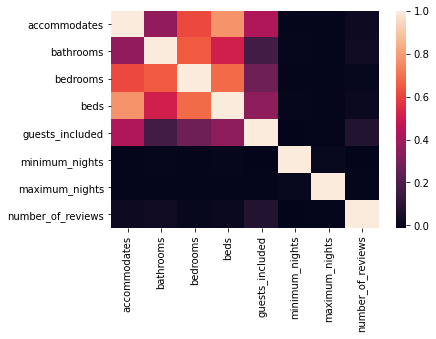

In [17]:
sns.heatmap(df_numerical.corr())

In [18]:
corr_mask = np.triu(np.ones_like(df_numerical.corr().abs(), dtype = bool))
df_numerical_corr_masked = df_numerical.corr().abs().mask(corr_mask)

numerical_col_to_remove = [ c for c in df_numerical_corr_masked.columns if any(df_numerical_corr_masked[c] > 0.8)]

In [19]:
df_numerical['mean_num_nights'] = (df_numerical['minimum_nights'] + df_numerical['maximum_nights'])/2
df_numerical.drop(['minimum_nights','maximum_nights'], axis=1, inplace=True)

<ipython-input-19-3b2f54f4ee42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical['mean_num_nights'] = (df_numerical['minimum_nights'] + df_numerical['maximum_nights'])/2
/home/natsunami/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
priced_col = ['price','security_deposit','cleaning_fee','extra_people']

for col in priced_col:
    df_others[col] = df_others[col].str.replace('$','').str.replace(",","").astype('float')

<ipython-input-20-0bdee256f200>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_others[col] = df_others[col].str.replace('$','').str.replace(",","").astype('float')


In [21]:

def amenities_cleaning(x):
    x =  len(x.replace('{','').replace('}','').split(','))
    return x

df_others['amenities'] = df_others['amenities'].apply(lambda x: amenities_cleaning(x))

<ipython-input-21-b348a435bc77>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_others['amenities'] = df_others['amenities'].apply(lambda x: amenities_cleaning(x))


In [22]:
zipcode_mask = df_others['zipcode'].value_counts().index[df_others['zipcode'].value_counts() < 800]
mask_isin_zipcode = df_others['zipcode'].isin(zipcode_mask)
df_others['zipcode'][mask_isin_zipcode] = 'Other'
df_others['zipcode_clean'] = df_others['zipcode'].astype('str').apply(lambda x: x.replace(".0",""))
df_others.drop(['zipcode'], axis=1,inplace=True)

<ipython-input-22-f5aae3f715ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_others['zipcode'][mask_isin_zipcode] = 'Other'
/home/natsunami/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-22-f5aae3f715ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_

In [23]:
exotic_properties = df_others['property_type'].value_counts()[df_others['property_type'].value_counts() < 10].index
mask_isin_exotic = df_others['property_type'].isin(exotic_properties)
df_others['property_type'][mask_isin_exotic] = 'Exotic'

<ipython-input-23-5ab677417e66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_others['property_type'][mask_isin_exotic] = 'Exotic'
/home/natsunami/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [24]:
df_others['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

In [25]:
df_others['bed_type'].unique()

array(['Real Bed', 'Pull-out Sofa', 'Couch', 'Futon', 'Airbed', nan],
      dtype=object)

In [26]:
df_others

,property_type,room_type,bed_type,amenities,price,security_deposit,cleaning_fee,extra_people,zipcode_clean
0,Loft,Entire home/apt,Real Bed,13,125.0,0.0,40.0,0.0,75010
1,Apartment,Entire home/apt,Real Bed,16,60.0,150.0,60.0,0.0,75014
2,Apartment,Entire home/apt,Pull-out Sofa,22,115.0,0.0,36.0,0.0,75004
3,Apartment,Entire home/apt,Real Bed,30,119.0,200.0,50.0,10.0,75004
4,Apartment,Entire home/apt,Real Bed,12,130.0,500.0,60.0,20.0,75009
...,...,...,...,...,...,...,...,...,...
66895,Apartment,Entire home/apt,Real Bed,15,60.0,NaN,35.0,0.0,75116
66896,Apartment,Private room,Real Bed,19,40.0,NaN,NaN,0.0,75010
66897,Apartment,Entire home/apt,Real Bed,11,32.0,NaN,NaN,0.0,75010
66898,Apartment,Entire home/apt,Real Bed,8,65.0,NaN,NaN,0.0,75012


In [27]:
df_numerical['mean_num_nights'] = (df_numerical['minimum_nights'] + df_numerical['maximum_nights'])/2

KeyError: 'minimum_nights'

In [73]:
df.shape

(66900, 16)

In [29]:
df = pd.concat([df_others,df_numerical], axis=1)

In [30]:
df.shape

(66900, 16)

In [119]:
price_log = df['price'].apply(lambda x: np.log1p(x))

In [121]:
np.expm1(price_log)

0        125.0
1         60.0
2        115.0
3        119.0
4        130.0
         ...  
66895     60.0
66896     40.0
66897     32.0
66898     65.0
66899     30.0
Name: price, Length: 66900, dtype: float64

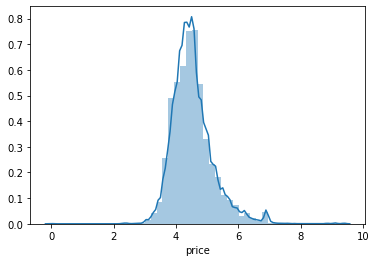

In [120]:
fig, ax = plt.subplots()

sns.distplot(price_log, ax=ax)
plt.show()

In [33]:
df.columns
numerical_columns = ['amenities','security_deposit', 'cleaning_fee', 'extra_people','accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included','number_of_reviews', 'mean_num_nights']
categorical_columns = ['property_type', 'room_type', 'bed_type','zipcode_clean']

In [34]:
y = df['price']
X = df.drop(['price'], axis=1)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X,price_log, shuffle=True, random_state= 42)

In [123]:
numerical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),('scaler',RobustScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('encoder',TargetEncoder())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)])

#preprocessor_pca = Pipeline(steps=[('preprocess',preprocessor),('pca',T(n_components=0.90))])


In [124]:
X_train_processed = preprocessor.fit_transform(X_train,y_train)
X_test_processed = preprocessor.transform(X_test)

/home/natsunami/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [89]:
X_train_processed.shape

(50175, 15)

In [125]:
#Baseline model with linear regression:
lr = LinearRegression()

lr.fit(X_train_processed,y_train)
y_pred_train_lr = lr.predict(X_train_processed)
rmse_train_lr = mean_squared_error(y_train, y_pred_train_lr, squared=False)
r2_train_lr = r2_score(y_train, y_pred_train_lr)

#cv_rfr_lr_rmse = -cross_val_score(lr,X_train_processed, y_train, scoring=['neg_root_mean_squared_error','r2'], cv=10, n_jobs=-1).mean()
#cv_rfr_lr_r2 = -cross_val_score(lr,X_train_processed, y_train, scoring='r2', cv=10, n_jobs=-1).mean()
cross_validate(lr,X_train_processed, y_train, scoring=['neg_root_mean_squared_error','r2'], cv=10, n_jobs=-1)

{'fit_time': array([0.0327909 , 0.03694129, 0.04035306, 0.03677917, 0.03645968,
        0.02876472, 0.04592466, 0.03908801, 0.03917599, 0.0307622 ]),
 'score_time': array([0.00156808, 0.00167799, 0.00188351, 0.0016129 , 0.00159049,
        0.00124192, 0.00223279, 0.00129747, 0.00159335, 0.00133181]),
 'test_neg_root_mean_squared_error': array([-0.53057338, -6.42348643, -0.50951897, -0.52288629, -0.55225598,
        -0.52329729, -0.51548293, -0.53920349, -0.48861425, -0.55910291]),
 'test_r2': array([  0.38309339, -91.36090551,   0.39510556,   0.40355   ,
          0.35944349,   0.39425945,   0.40358984,   0.35796981,
          0.4295519 ,   0.31473527])}

In [126]:
#Baseline model with random forest regression:
rfr  = RandomForestRegressor()

rfr.fit(X_train_processed,y_train)
y_pred_train = rfr.predict(X_train_processed)
rmse_train_rfr = mean_squared_error(y_train, y_pred_train, squared=False)
r2_train_rfr = r2_score(y_train, y_pred_train)


cv_rfr  = cross_validate(rfr,X_train_processed, y_train, scoring=['neg_root_mean_squared_error','r2'], cv=5, n_jobs=-1)


In [127]:
cv_rfr

{'fit_time': array([23.87302279, 23.94689202, 18.14263058, 18.21764827, 18.55319452]),
 'score_time': array([0.30594492, 0.30824614, 0.40203309, 0.39468288, 0.39539123]),
 'test_neg_root_mean_squared_error': array([-0.41361894, -0.40957188, -0.42357316, -0.41465441, -0.41142141]),
 'test_r2': array([0.62109889, 0.62208635, 0.61355459, 0.61721178, 0.61298204])}

In [128]:
params = {'n_estimators':range(100,1000,50),
         'max_depth':range(1,30),
         'min_samples_leaf':range(1,20),
         'max_features':['auto','sqrt','log2']}

rand_search_rfr = RandomizedSearchCV(rfr,params,n_iter=20, cv=5, n_jobs=-1)
rand_search_rfr_results = rand_search_rfr.fit(X_train_processed, y_train)

In [129]:
pd.DataFrame(rand_search_rfr_results.cv_results_, columns=rand_search_rfr_results.cv_results_.keys()
            )

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,65.764208,0.580043,2.806925,0.039420,950,4,log2,23,"{'n_estimators': 950, 'min_samples_leaf': 4, '...",0.613076,0.611071,0.603488,0.605350,0.618024,0.610202,0.005269,4
1,22.571289,2.343089,0.653169,0.094176,700,2,log2,7,"{'n_estimators': 700, 'min_samples_leaf': 2, '...",0.516318,0.515896,0.511701,0.509009,0.528932,0.516371,0.006841,17
2,23.760550,0.597599,0.865942,0.019197,400,5,log2,14,"{'n_estimators': 400, 'min_samples_leaf': 5, '...",0.596969,0.593908,0.588250,0.588501,0.601633,0.593852,0.005104,6
3,219.798049,0.701921,2.601931,0.062763,900,4,auto,18,"{'n_estimators': 900, 'min_samples_leaf': 4, '...",0.625464,0.621433,0.618928,0.615781,0.617552,0.619832,0.003368,2
4,153.114083,0.854855,1.498576,0.021368,900,12,auto,11,"{'n_estimators': 900, 'min_samples_leaf': 12, ...",0.589555,0.585663,0.583438,0.579800,0.587318,0.585155,0.003344,8
5,5.444565,0.037854,0.217461,0.001322,100,18,log2,22,"{'n_estimators': 100, 'min_samples_leaf': 18, ...",0.571084,0.570768,0.562601,0.562805,0.581046,0.569661,0.006778,14
6,19.066264,0.257433,0.718176,0.017799,350,9,log2,14,"{'n_estimators': 350, 'min_samples_leaf': 9, '...",0.583923,0.582572,0.575241,0.574445,0.591978,0.581632,0.006413,10
7,142.037833,1.068754,1.471398,0.032244,700,3,auto,13,"{'n_estimators': 700, 'min_samples_leaf': 3, '...",0.615190,0.613795,0.610952,0.607899,0.610959,0.611759,0.002534,3
8,94.559568,1.698492,1.048523,0.012281,450,19,auto,25,"{'n_estimators': 450, 'min_samples_leaf': 19, ...",0.598539,0.592209,0.587667,0.585353,0.593521,0.591458,0.004617,7
9,115.958256,0.849707,0.950861,0.024409,900,6,auto,7,"{'n_estimators': 900, 'min_samples_leaf': 6, '...",0.545927,0.539257,0.540951,0.537474,0.538177,0.540357,0.003022,16


In [130]:
rand_search_rfr_results.best_score_

0.6330533664069835

In [131]:
xboost = xgb.XGBRegressor()

xgb_cross_val = cross_validate(xboost, X_train_processed, y_train, scoring=['neg_root_mean_squared_error','r2'], cv=10,n_jobs=-1)

In [132]:
xgb_cross_val['test_r2'].mean()

0.6522801610924582

In [133]:
params_xgb = {'n_estimators':range(100,1000,25),
         'max_depth':range(1,30),
         'min_samples_leaf':range(1,20),
         'learning_rate':np.linspace(0.001,0.3,num=50),
         'booster':['gbtree', 'gbdart'],
         'reg_alpha':np.linspace(0.01,0.5,num=50)}

rand_search_xgb = RandomizedSearchCV(xboost,params_xgb,n_iter=30, cv=5, n_jobs=-1)
rand_search_xgb_results = rand_search_xgb.fit(X_train_processed, y_train)

/home/natsunami/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [135]:
rand_search_xgb_results.best_params_

{'reg_alpha': 0.25,
 'n_estimators': 125,
 'min_samples_leaf': 6,
 'max_depth': 9,
 'learning_rate': 0.0620204081632653,
 'booster': 'gbtree'}